In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from la_forge.core import Core
import scipy.linalg as sl
from statsmodels.stats.correlation_tools import cov_nearest

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils

In [2]:
datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'
parfiles = sorted(glob(datadir + '/*.par'))
timfiles = sorted(glob(datadir + '/*.tim'))

psrs = [Pulsar(par,tim) for par,tim in zip(parfiles,timfiles)]

inj_params = {'gw_log10_A':np.log10(5e-14)}

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.MarginalizingTimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

In [4]:
OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',core_path='MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


In [5]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(params=inj_params,pair_covariance=True,narrowband=False)
fgw = OS_obj.freqs

_,_,_,_,tr_Sk,tr_Sks = OS_obj.compute_PFOS(params=inj_params,pair_covariance=False,narrowband=False)
fgw = OS_obj.freqs

100%|██████████| 10/10 [00:00<00:00, 1192.21it/s]


In [6]:
xi_range = np.linspace(0.01,np.pi,1000)
hd_mod = utils.orf_xi(xi_range,'hd')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)

In [7]:
problem_freq = 4
sig_ab = sigk[problem_freq]
ORF = OS_obj.orf_design_matrix
data = rhok[problem_freq]
cov = Ck[problem_freq]

xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],
                                                     Ck[problem_freq],
                                                     bins=15,orf='hd')

# non-PC solution
tr_A2 = tr_Sk[problem_freq]
tr_A2s = tr_Sks[problem_freq]

/Users/gersbaka/Documents/Projects/defiant/notebooks/../defiant/utils.py:333: RuntimeWarning: invalid value encountered in sqrt
  sigavg[i] = np.abs(bin_orf)*np.sqrt(s2)


In [8]:
print(tr_A2,'\n',tr_A2s)

[-3.43589345e-16  3.33534007e-16 -8.50404267e-17] 
 [[ 6.08198010e-30 -2.77832698e-31 -2.21031903e-31]
 [-2.77832698e-31  4.13536504e-31  2.88125002e-33]
 [-2.21031903e-31  2.88125002e-33  1.68106902e-31]]


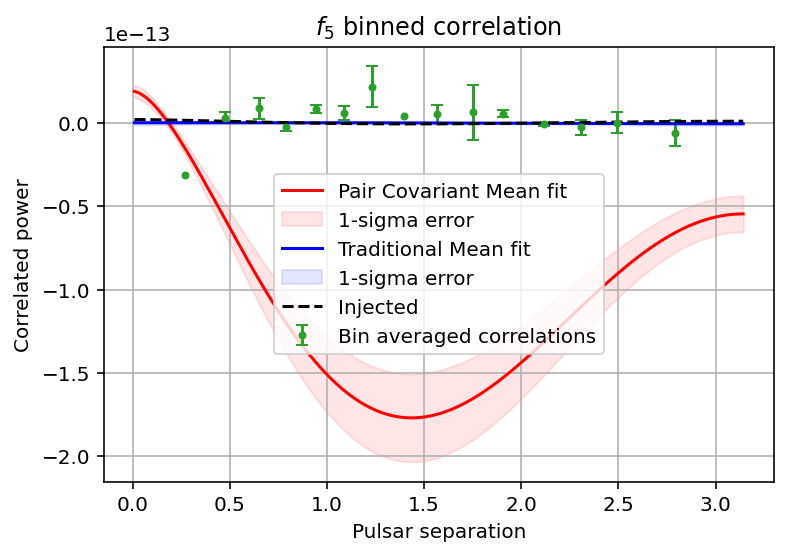

In [9]:
plt.title(f'$f_{problem_freq+1}$ binned correlation')

plt.errorbar(xiBin,rhoBin,sigBin,fmt='.C2',capsize=3,label='Bin averaged correlations')

mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,Sk[problem_freq],Sks[problem_freq],['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-r',label='Pair Covariant Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='r',alpha=0.1,label='1-sigma error')

mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,tr_A2,tr_A2s,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-b',label='Traditional Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='b',alpha=0.1,label='1-sigma error')


plt.plot(xi_range,inj_pl[problem_freq]*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

### A New way to fit

In [13]:
cho_fac = sl.cho_factor(cov)

fisher_inv = ORF.T @ sl.cho_solve(cho_fac,ORF)

dirtymap = ORF.T @ sl.cho_solve(cho_fac,data)

A2 = fisher_inv@dirtymap
A2s = fisher_inv
print(A2,'\n',A2s)

print(tr_A2,'\n',tr_A2s)

LinAlgError: 7-th leading minor of the array is not positive definite

In [14]:
fisher_inv = ORF.T @ np.linalg.solve(cov,ORF)

dirtymap = ORF.T @ np.linalg.solve(cov,data)

A2 = fisher_inv@dirtymap
A2s = fisher_inv
print(A2,'\n',A2s)

print(tr_A2,'\n',tr_A2s)

[4.12873729e+43 1.24588321e+44 9.19274067e+43] 
 [[2.42338704e+28 5.40905038e+28 5.35381614e+28]
 [5.40905038e+28 1.93989234e+29 1.19882814e+29]
 [5.35381614e+28 1.19882814e+29 1.20834222e+29]]
[-3.43589345e-16  3.33534007e-16 -8.50404267e-17] 
 [[ 6.08198010e-30 -2.77832698e-31 -2.21031903e-31]
 [-2.77832698e-31  4.13536504e-31  2.88125002e-33]
 [-2.21031903e-31  2.88125002e-33  1.68106902e-31]]


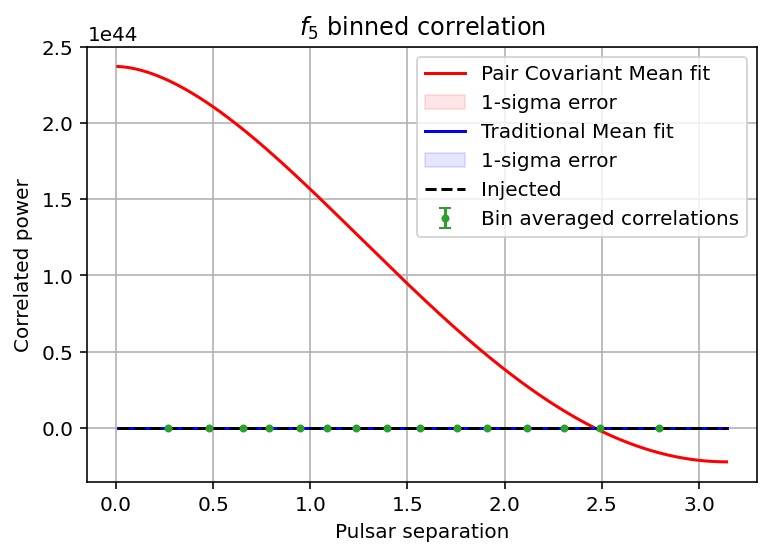

In [15]:
plt.title(f'$f_{problem_freq+1}$ binned correlation')

plt.errorbar(xiBin,rhoBin,sigBin,fmt='.C2',capsize=3,label='Bin averaged correlations')


mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,A2,A2s,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-r',label='Pair Covariant Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='r',alpha=0.1,label='1-sigma error')


mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,tr_A2,tr_A2s,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-b',label='Traditional Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='b',alpha=0.1,label='1-sigma error')


plt.plot(xi_range,inj_pl[problem_freq]*hd_mod,'--k',label='Injected')


plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()